### Notebook to do inference on a new image

In [331]:
# Load
import torch
from lightning import Trainer
from torch.utils.data import DataLoader
import numpy as np
from scipy.ndimage import zoom
from src.data.dataset import Dataset
from src.modules.lightning_cnn import LitCNN
from src.utils.optimization import Optimization
import nibabel as nib
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt
import os

sub_id="010" #To be changed
base_path_1=r"/home/ubuntu/giorgio/v311/FeTa_challenge_2024" #To be changed 
IMG256_PATH= os.path.join(base_path_1, f'sub-{sub_id}_rec-mial_T2w.nii.gz' ) #mial
MODEL_PATH = r"/home/ubuntu/giorgio/v311/lightning_logs/brain_model/version_111/checkpoints/epoch=29-step=180.ckpt"
IMG_PATH = os.path.join(base_path_1, r"goundtruth_testBosisio/goundtruth", f'sub-{sub_id}_dseg_warped_0.5mm.nii.gz' )
MRI_PATH = os.path.join(base_path_1, r"MRI_testBosisio/images", f'sub-{sub_id}_brain_warped_0.5mm.nii.gz' )

#TO BE MANUALLY CHANGE
TRANS_FILE = os.path.join(base_path_1, f'0GenericAffine.mat') #0GenericAffine_{sub_id}

OUT_PATH = r"/home/ubuntu/giorgio/v311/FeTa_challenge_2024"

def resize(array: np.array,) :
    target_shape = (128, 128, 128)

    # Calculate zoom factors
    original_shape = array.shape
    zoom_factors = [t / o for t, o in zip(target_shape, original_shape)]

    # Resize the array using nearest-neighbor interpolation
    resized_array = zoom(array, zoom_factors, order=0)  # 'order=0' for nearest-neighbor interpolation
    return resized_array

def reshape_output(
    y_hat: torch.Tensor,
) -> torch.Tensor:
    """
    Reshape the output tensor (1,30) of the model to the (10,3) model.

    Parameters:
    - y_hat (torch.Tensor): Predicted tensor (1,30) from the model.

    Returns:
    - torch.Tensor: output tensor with resized shape.

    """
    y_hat_new = y_hat.cpu().data.numpy()
    y_hat_new = y_hat_new.reshape(10,3)

    return y_hat_new

In [332]:
def normalize_brain_hu(brains, background=1) -> None:
    """Normalize the mri corresponding to the density.

    Can be defined in a better way with the masks.
    """
    for i, brain in enumerate(brains):
        non_zero_values = brain[np.nonzero(brain)]
        min_value = np.min(non_zero_values) if background == 0 else np.min(brain)
        max_value = np.max(non_zero_values) if background == 0 else np.max(brain)
        difference = max_value - min_value
        normalized = (
            np.where(brain != 0, (brain - min_value) / difference, background)
            if background == 0
            else (brain - min_value) / difference
        )

        brains[i] = normalized
    return brains

In [333]:
def import_img(IMG_PATH:str, MRI_PATH:str):
    raw_img = nib.load(IMG_PATH)
    my_img = raw_img.get_fdata()
    raw_MRI = nib.load(MRI_PATH)
    my_MRI = raw_MRI.get_fdata()
    resized_img = resize(my_img)
    #resized_img=normalize_brain_hu(resized_img)
    resized_MRI = resize(my_MRI)
    resized_img=np.expand_dims(resized_img, axis=0)
    resized_img=np.expand_dims(resized_img, axis=0)
    # Verify the result
    print(resized_img.shape)
    return resized_img, resized_MRI

resized_img, resized_MRI = import_img(IMG_PATH, MRI_PATH) 

(brains,
    y_reg,
    predict_index,
) = tuple(
    map(
        torch.Tensor,
        (
            resized_img,
            [np.ones(30)],
            1,
        ),
    )
)
pred_dataset = TensorDataset(
    brains,
    y_reg,
    predict_index,
)

dataset = pred_dataset
lightning_cnn = LitCNN.load_from_checkpoint(checkpoint_path=MODEL_PATH)

prediction_loader = DataLoader(
    dataset,
    num_workers=0,
)

trainer = Trainer(logger=False)

biometry=trainer.predict(lightning_cnn, dataloaders=prediction_loader, return_predictions=True)
biometry=reshape_output(biometry[0])
old_bio=biometry

(1, 1, 128, 128, 128)


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 189.76it/s]


### Per visualizzare i risultati

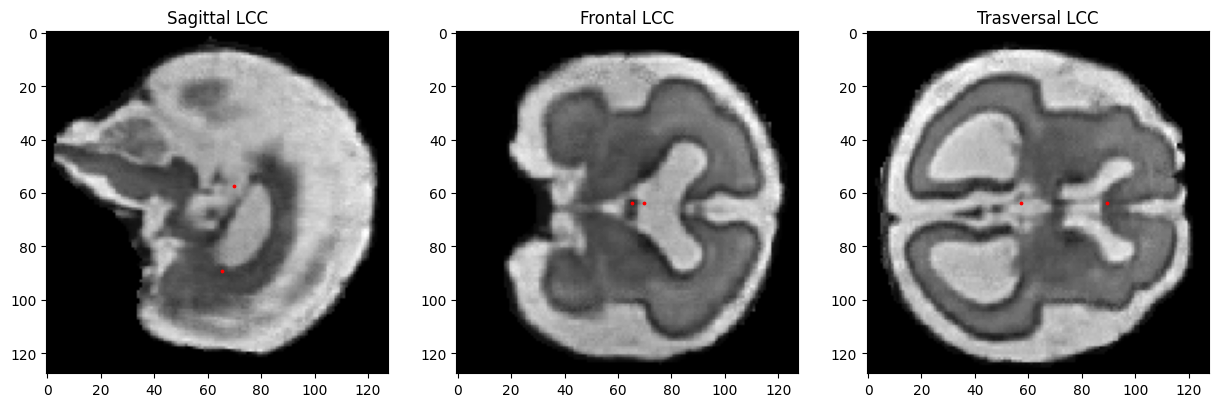

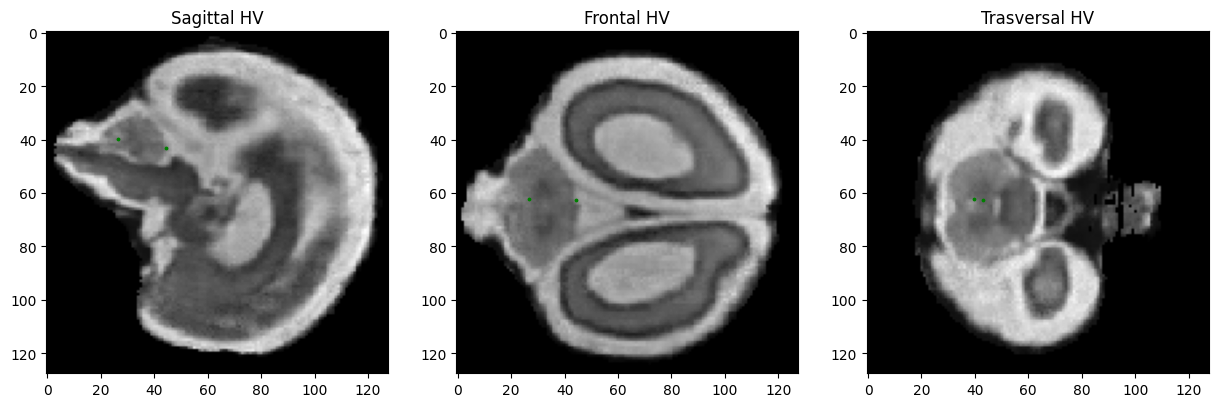

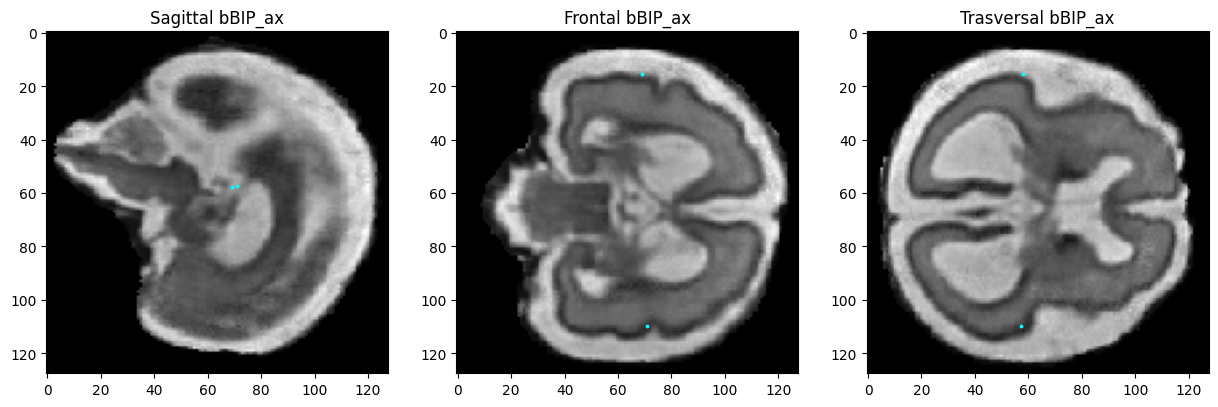

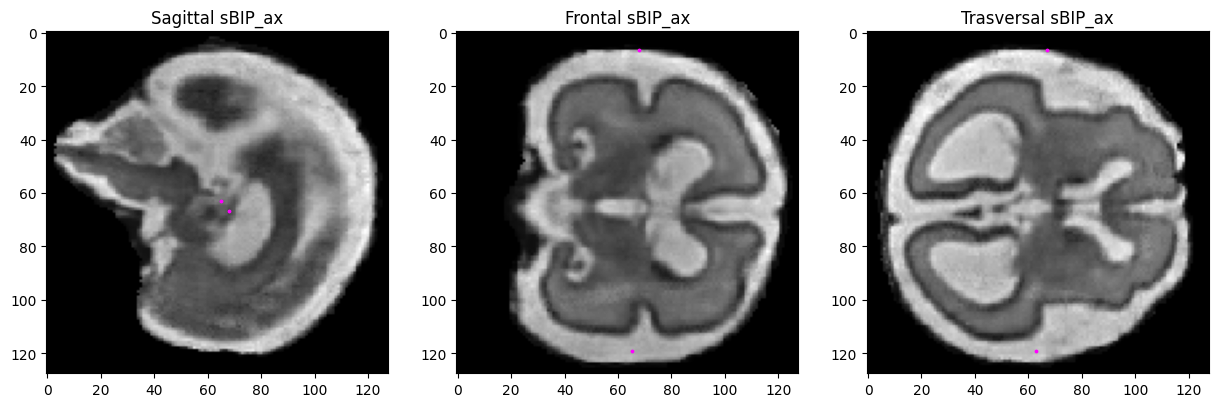

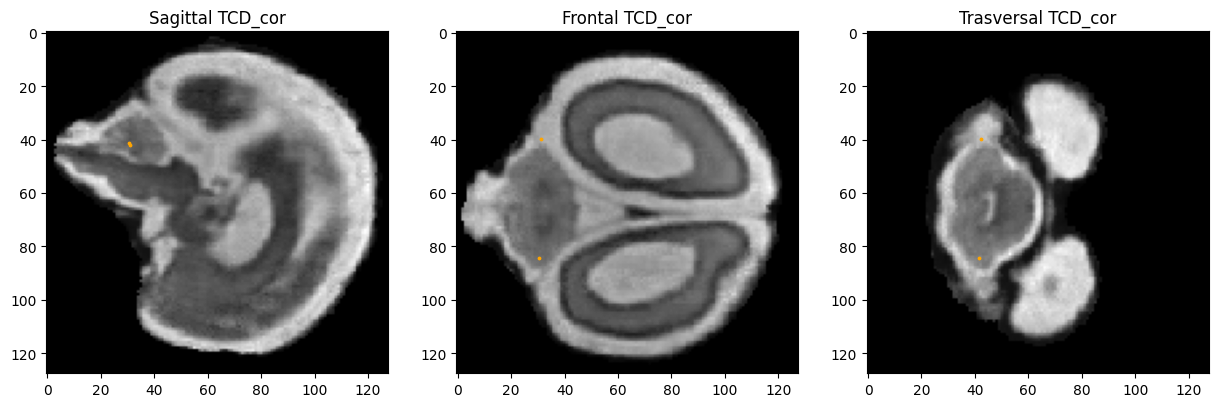

In [334]:
import matplotlib.pyplot as plt

x_positions, y_positions, z_positions = biometry[:,0],biometry[:,1],biometry[:,2]
visualize=resized_MRI

color_dict = {
    0: 'red',
    1: 'green',
    2: 'cyan',
    3: 'magenta',
    4: 'orange'
}

bio_dict = {
    0: 'LCC',
    1: 'HV',
    2: 'bBIP_ax',
    3: 'sBIP_ax',
    4: 'TCD_cor'
}

# Display each image in a subplot
for i in range(5):
    #i=i+1
    organ=bio_dict[i]
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(visualize[int((x_positions[2*i]+x_positions[2*i+1])/2),:,:],cmap='gray')
    axs[0].set_title(f'Sagittal {organ}')
    axs[0].scatter(z_positions[2*i],y_positions[2*i], c=color_dict[i], s=3)
    axs[0].scatter(z_positions[2*i+1],y_positions[2*i+1], c=color_dict[i], s=3)

    axs[1].imshow(visualize[:,int((y_positions[2*i]+y_positions[2*i+1])/2),:],cmap='gray')
    axs[1].set_title(f'Frontal {organ}')
    axs[1].scatter(z_positions[2*i],x_positions[2*i], c=color_dict[i], s=3)
    axs[1].scatter(z_positions[2*i+1],x_positions[2*i+1], c=color_dict[i], s=3)

    axs[2].imshow(visualize[:,:,int((z_positions[2*i]+z_positions[2*i+1])/2)],cmap='gray')
    axs[2].set_title(f'Trasversal {organ}')
    axs[2].scatter(y_positions[2*i],x_positions[2*i], c=color_dict[i], s=3)
    axs[2].scatter(y_positions[2*i+1],x_positions[2*i+1], c=color_dict[i], s=3)

    # Display the plot
    plt.show()

### Fase di ottimizzazione

/home/ubuntu/giorgio/v311/FeTa_challenge_2024/src/utils/optimization.py:61: FutureWarning:

`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.

/home/ubuntu/giorgio/v311/FeTa_challenge_2024/src/utils/optimization.py:55: FutureWarning:

`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.



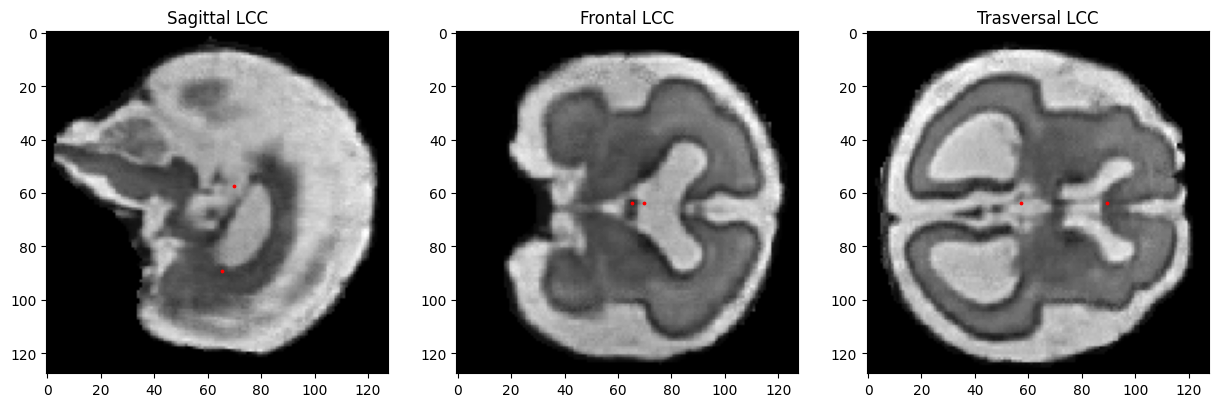

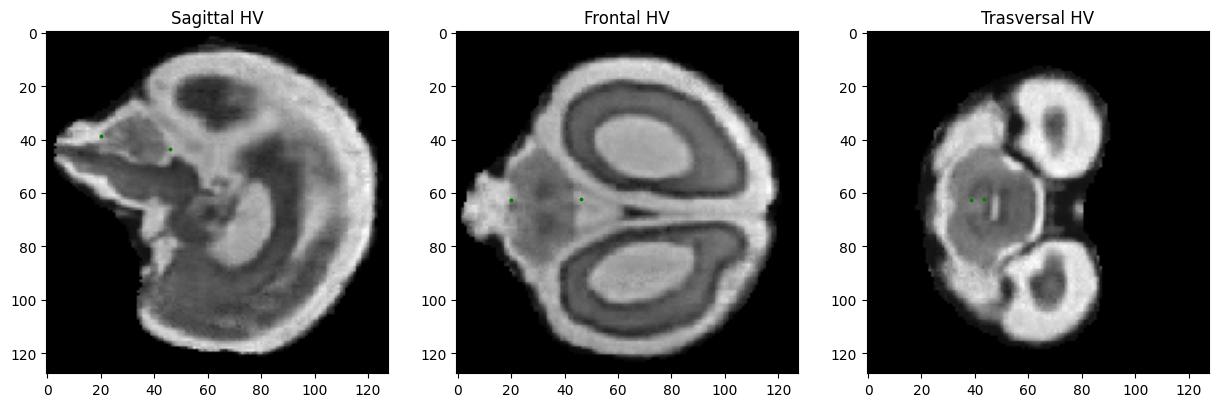

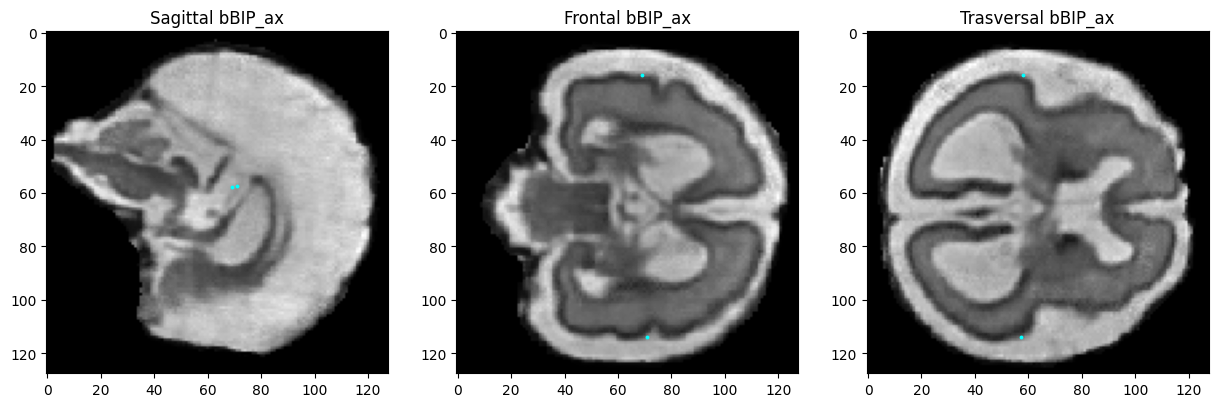

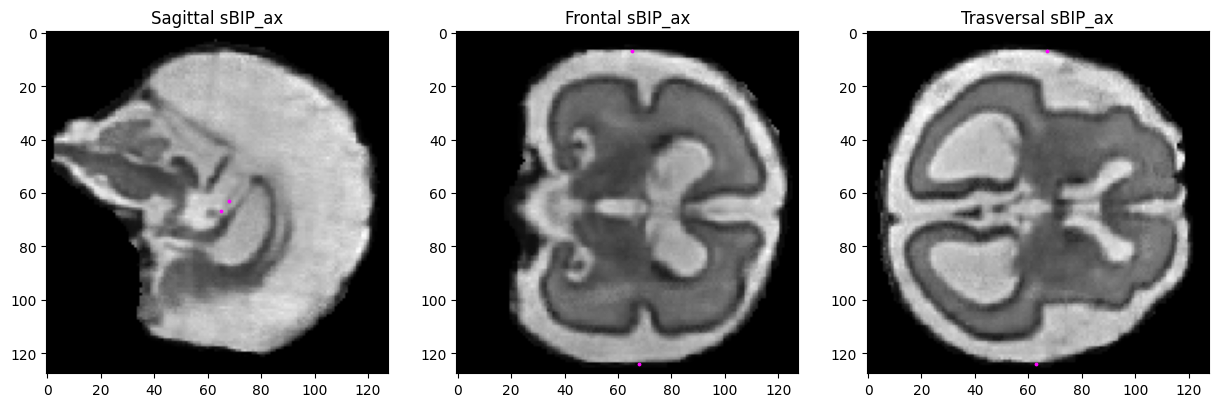

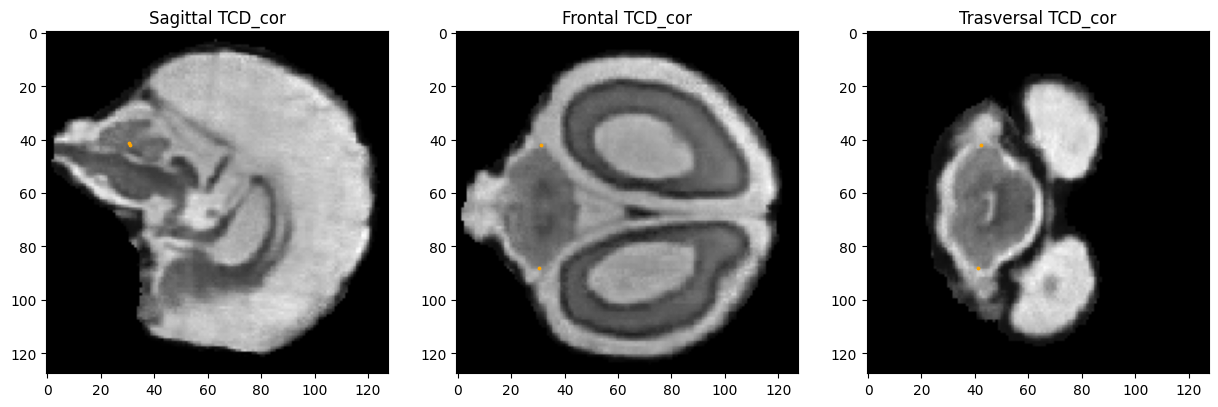

In [335]:
import matplotlib.pyplot as plt

opti= Optimization(resized_img, resized_MRI, biometry,)
opti.optimize()
biometry=opti.biometry
x_positions, y_positions, z_positions = biometry[:,0],biometry[:,1],biometry[:,2]
visualize=resized_img[0][0]
visualize=resized_MRI

color_dict = {
    0: 'red',
    1: 'green',
    2: 'cyan',
    3: 'magenta',
    4: 'orange'
}

bio_dict = {
    0: 'LCC',
    1: 'HV',
    2: 'bBIP_ax',
    3: 'sBIP_ax',
    4: 'TCD_cor'
}

# Display each image in a subplot
for i in range(5):
    #i=i+1
    organ=bio_dict[i]
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(visualize[int((x_positions[2*i]+x_positions[2*i+1])/2),:,:],cmap='gray')
    axs[0].set_title(f'Sagittal {organ}')
    axs[0].scatter(z_positions[2*i],y_positions[2*i], c=color_dict[i], s=3)
    axs[0].scatter(z_positions[2*i+1],y_positions[2*i+1], c=color_dict[i], s=3)

    axs[1].imshow(visualize[:,int((y_positions[2*i]+y_positions[2*i+1])/2),:],cmap='gray')
    axs[1].set_title(f'Frontal {organ}')
    axs[1].scatter(z_positions[2*i],x_positions[2*i], c=color_dict[i], s=3)
    axs[1].scatter(z_positions[2*i+1],x_positions[2*i+1], c=color_dict[i], s=3)

    axs[2].imshow(visualize[:,:,int((z_positions[2*i]+z_positions[2*i+1])/2)],cmap='gray')
    axs[2].set_title(f'Trasversal {organ}')
    axs[2].scatter(y_positions[2*i],x_positions[2*i], c=color_dict[i], s=3)
    axs[2].scatter(y_positions[2*i+1],x_positions[2*i+1], c=color_dict[i], s=3)

    # Display the plot
    plt.show()

TO DO


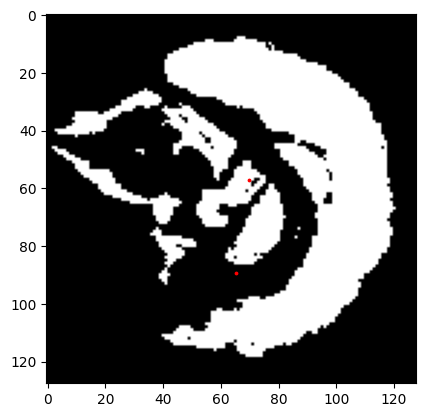

In [336]:
opti.segment_LCC()
opti.optimize_LCC()

### Testing

In [337]:
raw_img = nib.load(IMG256_PATH)
my_img = raw_img.get_fdata()

In [338]:
def reconstruct_sparse_matrix(coordinates_and_values, num_x=176, num_y=224, num_z=176):
    # Initialize a 3D matrix with zeros
    sparse_matrix = np.zeros((num_x, num_y, num_z))
    
    # Populate the matrix using the coordinates_and_values array
    for coord in coordinates_and_values:
        x, y, z, value = coord
        sparse_matrix[int(x), int(y), int(z)] = value
    
    return sparse_matrix

In [339]:
def inverse_resize(resized_array: np.array, keypoints: np.array, original_shape=(176,224,176)):
    # Calculate the inverse zoom factors
    zoom_factors = [o / t for t, o in zip(resized_array.shape, original_shape)]

    # Resize the array back to the original shape using nearest-neighbor interpolation
    original_array = zoom(resized_array, zoom_factors, order=0)  # 'order=0' for nearest-neighbor interpolation

    transformed_keypoints = np.array([(int(x * zoom_factors[0]), int(y * zoom_factors[1]), int(z * zoom_factors[2])) for x, y, z in keypoints])
    
    return original_array, transformed_keypoints

In [340]:
gerry_img = nib.load(IMG_PATH)
scotti_img = gerry_img.get_fdata()
gerry_matrix=gerry_img.affine

In [341]:
scotti_img.shape

(176, 224, 176)

In [342]:
data_orig, bio_orig=inverse_resize(resized_img[0][0], biometry)

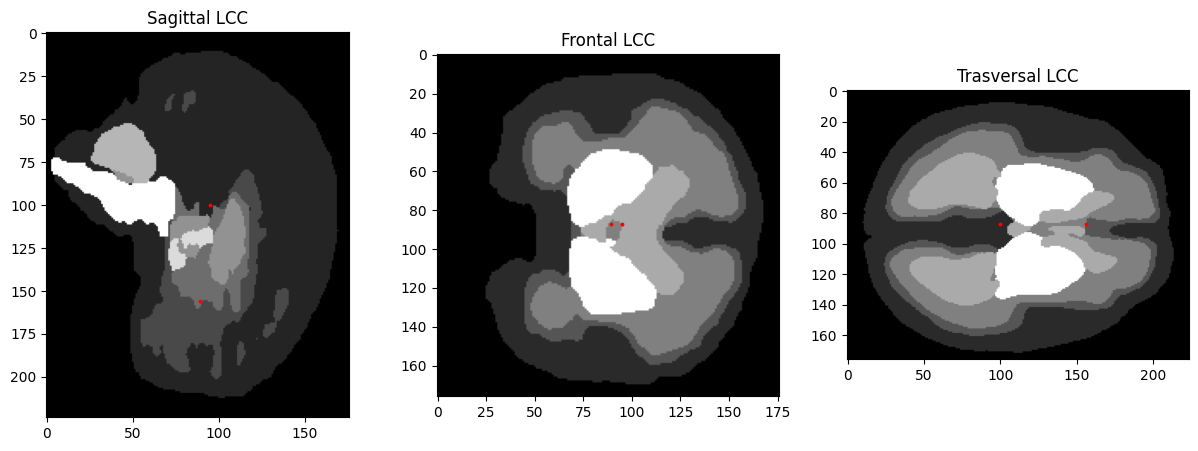

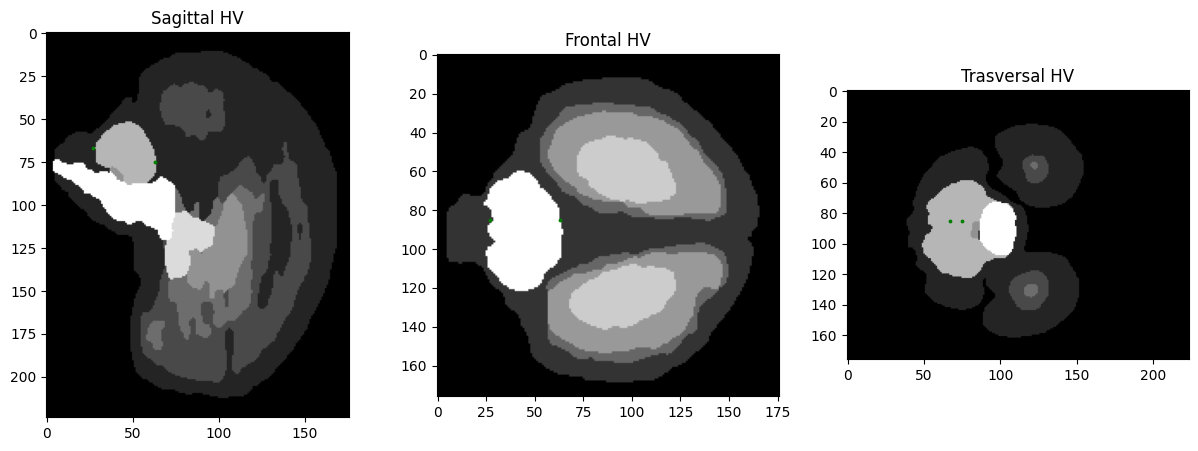

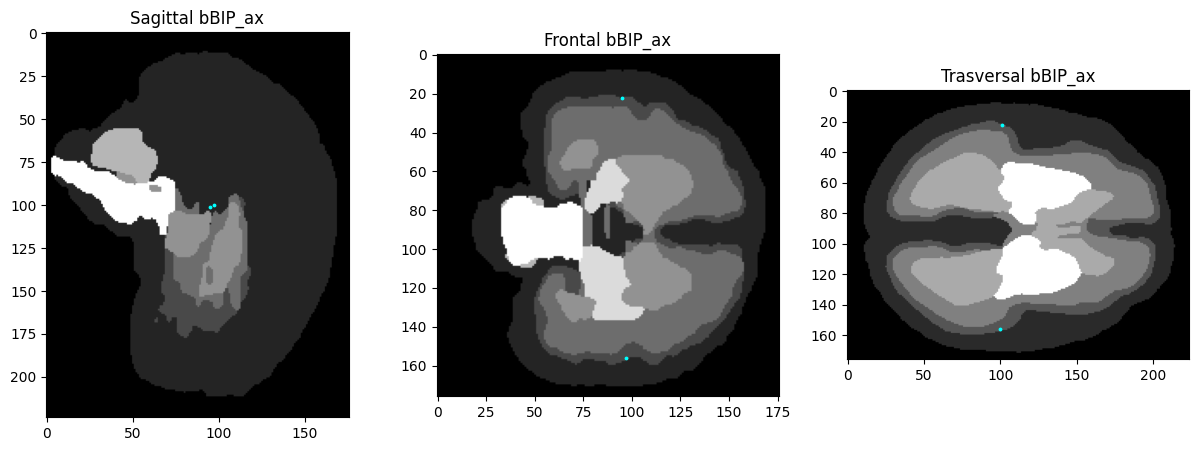

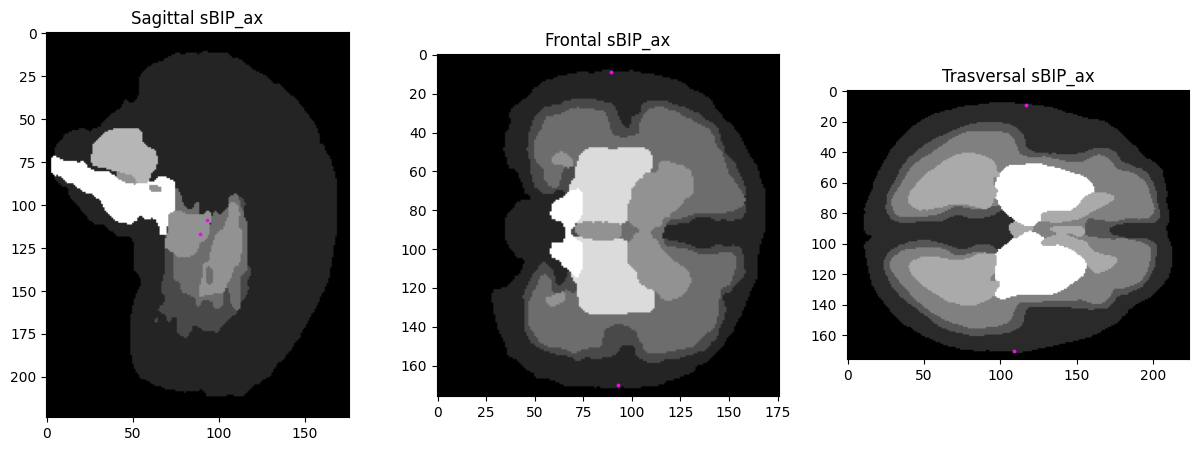

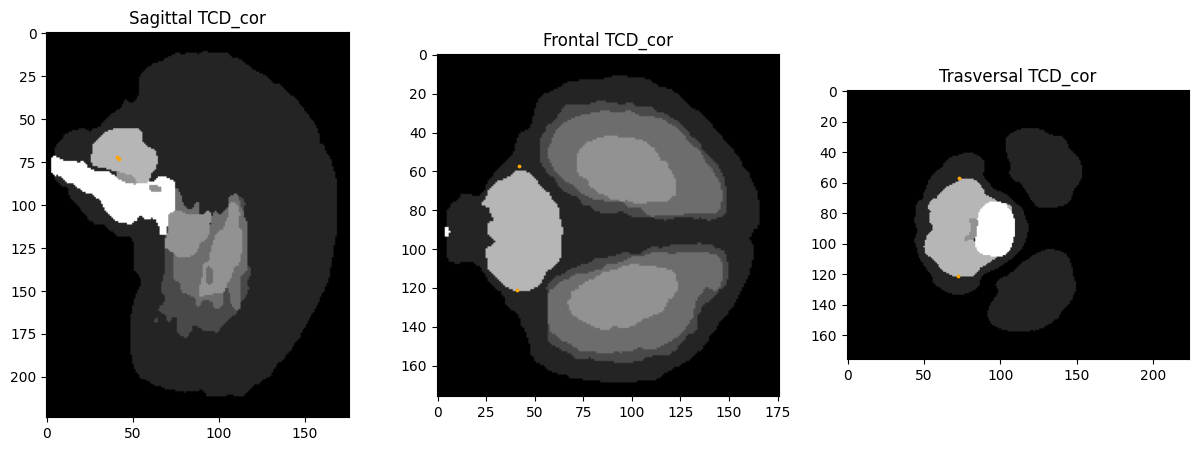

In [343]:
import matplotlib.pyplot as plt
x_positions, y_positions, z_positions = bio_orig[:,0],bio_orig[:,1],bio_orig[:,2]
visualize=scotti_img
#visualize=my_img

color_dict = {
    0: 'red',
    1: 'green',
    2: 'cyan',
    3: 'magenta',
    4: 'orange'
}

bio_dict = {
    0: 'LCC',
    1: 'HV',
    2: 'bBIP_ax',
    3: 'sBIP_ax',
    4: 'TCD_cor'
}

# Display each image in a subplot
for i in range(5):
    #i=i+1
    organ=bio_dict[i]
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(visualize[int((x_positions[2*i]+x_positions[2*i+1])/2),:,:],cmap='gray')
    axs[0].set_title(f'Sagittal {organ}')
    axs[0].scatter(z_positions[2*i],y_positions[2*i], c=color_dict[i], s=3)
    axs[0].scatter(z_positions[2*i+1],y_positions[2*i+1], c=color_dict[i], s=3)

    axs[1].imshow(visualize[:,int((y_positions[2*i]+y_positions[2*i+1])/2),:],cmap='gray')
    axs[1].set_title(f'Frontal {organ}')
    axs[1].scatter(z_positions[2*i],x_positions[2*i], c=color_dict[i], s=3)
    axs[1].scatter(z_positions[2*i+1],x_positions[2*i+1], c=color_dict[i], s=3)

    axs[2].imshow(visualize[:,:,int((z_positions[2*i]+z_positions[2*i+1])/2)],cmap='gray')
    axs[2].set_title(f'Trasversal {organ}')
    axs[2].scatter(y_positions[2*i],x_positions[2*i], c=color_dict[i], s=3)
    axs[2].scatter(y_positions[2*i+1],x_positions[2*i+1], c=color_dict[i], s=3)

    # Display the plot
    plt.show()

In [344]:
import ants
import nibabel as nib
values=np.array([1,1,2,2,3,3,4,4,5,5])
bio_val=np.column_stack((bio_orig, values))
a=reconstruct_sparse_matrix(bio_val)
output=os.path.join(base_path_1, f'sub-{sub_id}_bio.nii.gz')

# Create a NIfTI i  mage
img = nib.Nifti1Image(a, affine=gerry_matrix)

nib.save(img, output)
#ants.image_write(a, output)

In [345]:
import ants
fixed = ants.image_read(IMG256_PATH)
moving = ants.image_read( output)
mywarpedimage = ants.apply_transforms( fixed=fixed, moving=moving, transformlist= r"/home/ubuntu/giorgio/v311/FeTa_challenge_2024/0GenericAffine_134.mat", interpolator="nearestNeighbor",
                                      whichtoinvert=[True], singleprecision=True,
                                      )
output=os.path.join(base_path_1, f'sub-{sub_id}_gerry_bio.nii.gz')
ants.image_write(mywarpedimage, output)

In [346]:
carlo_img = nib.load(output)
conti_img = raw_img.get_fdata()

In [347]:
def load_biometry(path) -> np.array:
    bio=[]
    my_img = nib.load(path)
    nii_data = my_img.get_fdata()
    non_zero_positions = np.nonzero(nii_data)
    values = nii_data[non_zero_positions]
    x_positions, y_positions, z_positions = non_zero_positions
    coordinates_and_values = np.column_stack((x_positions, y_positions, z_positions, values))
    coordinates_and_values = coordinates_and_values[coordinates_and_values[:, -1].argsort()]
    bio.append(coordinates_and_values)
    return np.array(bio[0])

In [348]:
import fsl.data.image as fslimage
from scipy import ndimage
from scipy.cluster.hierarchy import fcluster, linkage
from scipy.spatial.distance import pdist, squareform

def biometry_transformer(fixed_path:str, moving_path:str, matrix_path:str, output_path:str ) -> None:
    
    image = fslimage.Image(moving_path)
    data = image.data

    # Define the structuring element for dilatation and perform the dilatation
    structuring_element = ndimage.generate_binary_structure(3, 3)
    dilated_data = ndimage.grey_dilation(data, footprint=np.ones((4,4,4)))

    dilated_image = fslimage.Image(dilated_data, header=image.header)
    dilated_image.save(output_path)

    fixed = ants.image_read(fixed_path)
    moving = ants.image_read( output_path)
    mywarpedimage = ants.apply_transforms(  fixed=fixed,
                                            moving=moving,
                                            transformlist= matrix_path,
                                            interpolator="nearestNeighbor",
                                            whichtoinvert=[True], 
                                            singleprecision=True,
                                            )
    
    ants.image_write(mywarpedimage, output_path)
    
def group_the_keypoints(array: np.array, threshold=3):
    def custom_distance(row1, row2, threshold=threshold):
        return 0 if np.all(np.abs(row1 - row2) <= threshold) else 1
    
    # Calculate the distance matrix
    distance_matrix = np.array([[custom_distance(row1, row2) for row2 in array] for row1 in array])
    # Perform hierarchical clustering
    Z = linkage(distance_matrix, method='complete')
    
    # Form clusters based on a threshold distance
    labels = fcluster(Z, t=2, criterion='maxclust')
    
    # Separate the rows into clusters
    cluster1 = array[labels == 1]
    cluster2 = array[labels == 2]
    
    # Calculate the averages of each cluster
    average_cluster1 = np.mean(cluster1, axis=0) if len(cluster1) > 0 else np.zeros(array.shape[1])
    average_cluster2 = np.mean(cluster2, axis=0) if len(cluster2) > 0 else np.zeros(array.shape[1])
    
    # Combine the averages into a single array
    label_1 = np.array([average_cluster1, average_cluster2])
    
    return label_1.astype(int)

In [349]:
f=  IMG256_PATH
m=  os.path.join(base_path_1, f'sub-{sub_id}_bio.nii.gz' )
mat= TRANS_FILE
biometry_transformer(f,m,mat,output)

In [350]:
testing_it = load_biometry(os.path.join(base_path_1, f'sub-{sub_id}_gerry_bio.nii.gz'))
print(testing_it)

[[ 93. 158.  90.   1.]
 [ 91. 106.  97.   1.]
 [ 91. 105.  99.   1.]
 [ 91. 105.  98.   1.]
 [ 91. 105.  97.   1.]
 [ 92. 108.  99.   1.]
 [ 92. 108.  98.   1.]
 [ 92. 108.  97.   1.]
 [ 92. 107.  99.   1.]
 [ 92. 107.  98.   1.]
 [ 92. 106.  99.   1.]
 [ 92. 106.  98.   1.]
 [ 92. 106.  97.   1.]
 [ 92. 105.  99.   1.]
 [ 92. 105.  98.   1.]
 [ 92. 105.  97.   1.]
 [ 91. 106.  98.   1.]
 [ 93. 157.  90.   1.]
 [ 93. 108.  99.   1.]
 [ 93. 108.  98.   1.]
 [ 93. 108.  97.   1.]
 [ 93. 107.  99.   1.]
 [ 93. 107.  98.   1.]
 [ 93. 107.  97.   1.]
 [ 93. 106.  99.   1.]
 [ 93. 106.  98.   1.]
 [ 93. 106.  97.   1.]
 [ 93. 105.  99.   1.]
 [ 93. 105.  98.   1.]
 [ 93. 105.  97.   1.]
 [ 95. 157.  91.   1.]
 [ 90. 107.  98.   1.]
 [ 95. 157.  92.   1.]
 [ 95. 159.  91.   1.]
 [ 95. 159.  90.   1.]
 [ 95. 158.  93.   1.]
 [ 95. 158.  92.   1.]
 [ 95. 158.  91.   1.]
 [ 95. 158.  90.   1.]
 [ 95. 157.  93.   1.]
 [ 95. 159.  92.   1.]
 [ 90. 108.  99.   1.]
 [ 90. 108.  98.   1.]
 [ 90. 108.

In [351]:
trasformed_biometry= np.empty((0, 4), dtype=int)
for i in range(5):
    selected_rows = group_the_keypoints(testing_it[testing_it[:, 3] == i+1])
    trasformed_biometry=np.concatenate((trasformed_biometry, selected_rows), axis=0)

print(trasformed_biometry)

/tmp/ipykernel_1427/631239883.py:37: ClusterWarning:

The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



[[ 91 106  97   1]
 [ 94 158  91   1]
 [ 90  72  32   2]
 [ 91  81  67   2]
 [ 23 113  98   3]
 [156 101  99   3]
 [  9 122  94   4]
 [169 114  93   4]
 [ 55  81  45   5]
 [119  76  47   5]]


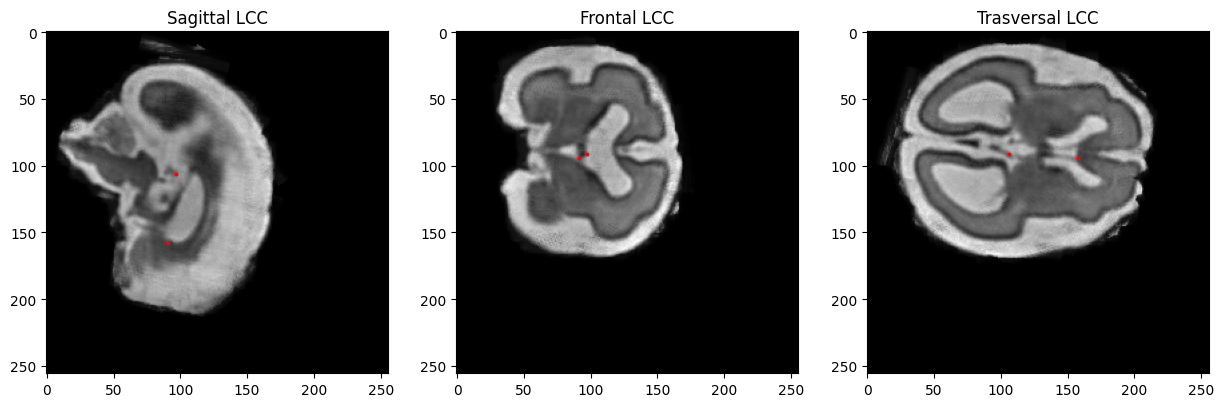

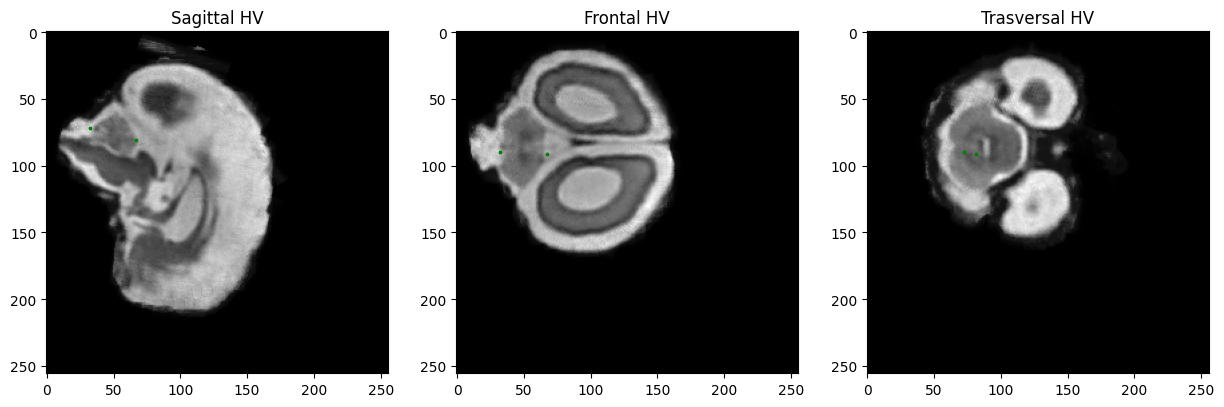

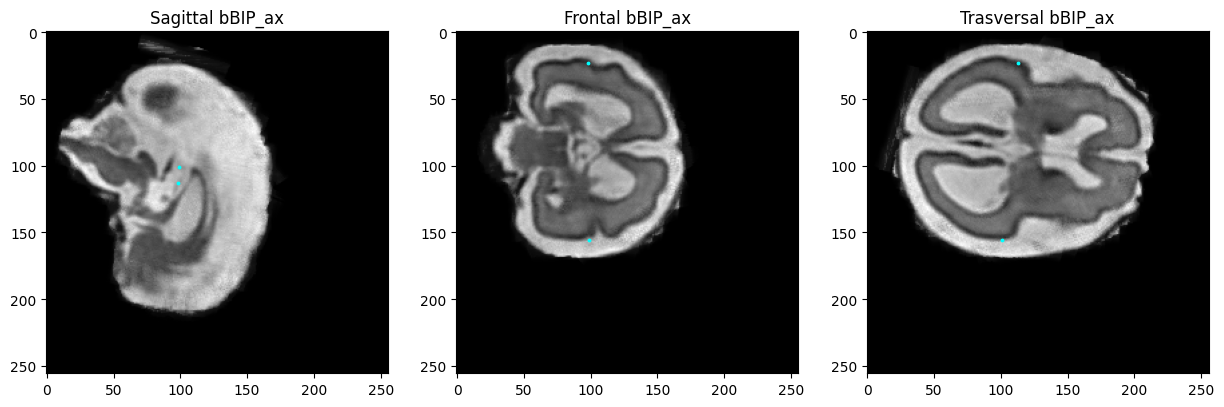

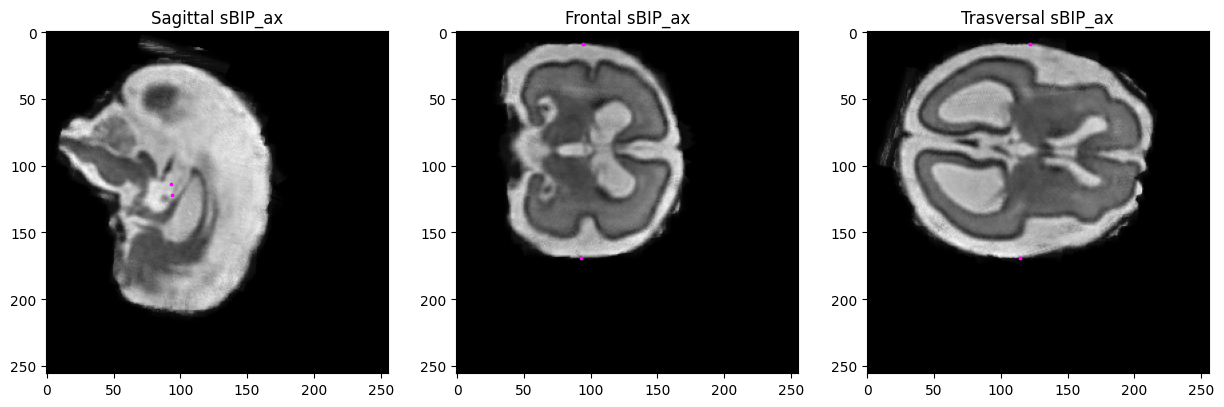

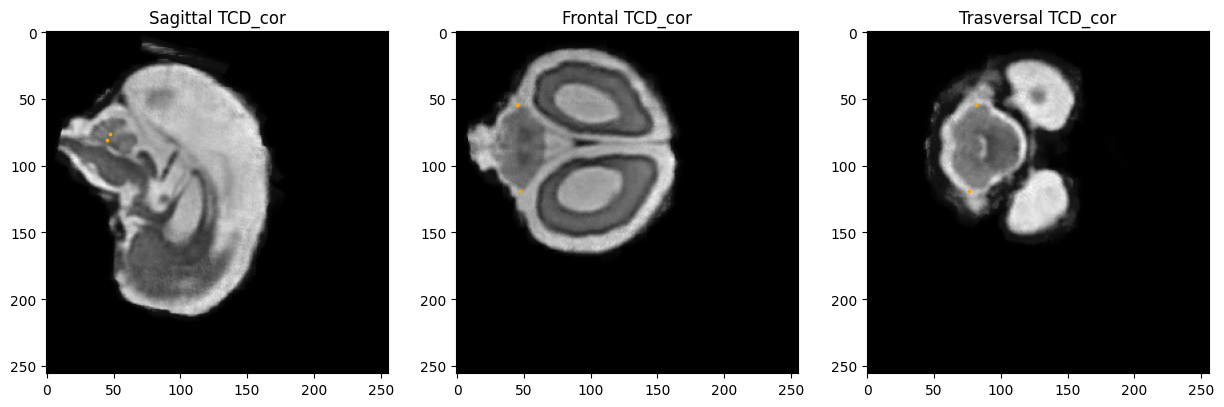

In [352]:
import matplotlib.pyplot as plt
testing_it=np.array(testing_it[0])
testing_it=trasformed_biometry
x_positions, y_positions, z_positions = testing_it[:,0],testing_it[:,1],testing_it[:,2]
visualize=resized_img[0][0]
visualize=my_img

color_dict = {
    0: 'red',
    1: 'green',
    2: 'cyan',
    3: 'magenta',
    4: 'orange'
}

bio_dict = {
    0: 'LCC',
    1: 'HV',
    2: 'bBIP_ax',
    3: 'sBIP_ax',
    4: 'TCD_cor'
}

# Display each image in a subplot
for i in range(5):
    #i=i+1
    organ=bio_dict[i]
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(visualize[int((x_positions[2*i]+x_positions[2*i+1])/2),:,:],cmap='gray')
    axs[0].set_title(f'Sagittal {organ}')
    axs[0].scatter(z_positions[2*i],y_positions[2*i], c=color_dict[i], s=3)
    axs[0].scatter(z_positions[2*i+1],y_positions[2*i+1], c=color_dict[i], s=3)

    axs[1].imshow(visualize[:,int((y_positions[2*i]+y_positions[2*i+1])/2),:],cmap='gray')
    axs[1].set_title(f'Frontal {organ}')
    axs[1].scatter(z_positions[2*i],x_positions[2*i], c=color_dict[i], s=3)
    axs[1].scatter(z_positions[2*i+1],x_positions[2*i+1], c=color_dict[i], s=3)

    axs[2].imshow(visualize[:,:,int((z_positions[2*i]+z_positions[2*i+1])/2)],cmap='gray')
    axs[2].set_title(f'Trasversal {organ}')
    axs[2].scatter(y_positions[2*i],x_positions[2*i], c=color_dict[i], s=3)
    axs[2].scatter(y_positions[2*i+1],x_positions[2*i+1], c=color_dict[i], s=3)

    # Display the plot
    plt.show()

In [353]:
import SimpleITK as sitk

REGION_DICT = {
    "LCC": 1,
    "HV": 2,
    "bBIP": 3,
    "sBIP": 4,
    "TCD": 5,
    }

def get_dist(im, region):
    """
    Get the distance between the two points of a given region.
    """
    x, y, z = np.where(sitk.GetArrayFromImage(im) == REGION_DICT[region])
    if len(x) == 0:
        return np.nan
    p1 = np.array([x[0], y[0], z[0]])
    p2 = np.array([x[1], y[1], z[1]])
    ip_res = im.GetSpacing()[0]
    assert len(x) == 2, f"Region {region} has {len(x)} points"
    dist = round(np.linalg.norm((p1 - p2) * ip_res), 2)
    return dist